# Project: Wrangle and Analyze Data
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#storing">Storing, Analyzing, and Visualizing Data</a></li>
</ul>

<a id='intro'></a>
## Introduction


In this project I work on a data set from the tweet archive of Twitter user @dog_rates, also known as __WeRateDogs__. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators are almost always greater than 10, like 11,12,13, etc. Since retweet count and favorite count are two notable columns missing, I'm going to query Twitter's API to gather this valuable data. We also have a table full of image predictions for each tweet.
<br>In particular my task in this project is __Data Wrangling__ on These three sources of data I have, and then __Analyzing, and Visualizing__ my wrangled data.


In [1]:
#import required libraries 
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gathering'></a>
## Gathering Data


We need to gather each of the three pieces of data

__ 1. WeRateDogs Twitter Archive __

In [2]:
#read csv file for WeRateDogs Twitter archive
twitter_archive = pd.read_csv('./Data/twitter-archive-enhanced.csv')

In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


__ 2. Tweet Image Predictions __

In [5]:
#download programmatically tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('./Data/image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

#read the downloaded tsv file
image_predictions = pd.read_csv('./Data/image_predictions.tsv', sep = '\t')

In [6]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


__ 3. Twitter API __

To gather each tweet's retweet count and favorite ('like') count, I'll use the tweet IDs in the WeRateDogs Twitter archive to query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data will be written to its own line. Then I'll read this .txt file line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.

In [7]:
#set required authentication values
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [8]:
#Create api object to gather Twitter data
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [9]:
# List of entire set of JSON data for tweets to write in a text file later
tweets_list = []
#List of tweet ids for tweets we can't find
errors_list = []

# Save the start time of execution
start = time.time()

for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        # Append to list of tweets
        tweets_list.append(tweet)
    
    #catch all exceptions    
    except Exception as e:
        print(str(tweet_id) + "_"  + str(e))
        errors_list.append(tweet_id)
    
# Calculate the time of execution
end = time.time()
print('execution time: ', end - start)    

888202515573088257_[{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921_[{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937_[{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329_[{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744_[{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320_[{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705_[{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648_[{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308_[{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977_[{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832_[{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464_[{'code': 144, 'message': 'No status found with that ID.'}]
771004394259247104_[{'code': 179, 'message': 'Sorry,

Rate limit reached. Sleeping for: 564


754011816964026368_[{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 572


execution time:  1883.3629608154297


In [10]:
print(len(tweets_list))

2341


In [11]:
print(len(errors_list))

15


Fifteen tweets couldn't be found on tweeter, They've probably been deleted.

In [12]:
# Wrtie JSON data for all tweets in a file
with open("./Data/tweet_json.txt", "w", encoding='utf-8') as file:
     for tweet in tweets_list:
        #write each tweet's JSON data on its own line
        file.write("%s\n" %json.dumps(tweet))


In [13]:
json_tweet_list = []
#Open the json file to read data line by line
with open("./Data/tweet_json.txt", "r") as json_file:
    for line in json_file:  # loop through entire file 
        json_tweet = json.loads(line)   #parses json data
        #save info to list of dicts
        json_tweet_list.append({'tweet_id':json_tweet['id'],
                                'retweet_count': json_tweet['retweet_count'],
                                'favorite_count': json_tweet['favorite_count']}) 
#Create a panda data frame from tweets' JSON data        
tweets_info = pd.DataFrame(json_tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

<a id='assessing'></a>
## Assessing Data


__1. Twitter archive dataset __

In [14]:
#With this piece of code the whole context of the columns in the dataframe will be visible after each command 
pd.set_option('display.max_colwidth', -1)

In [15]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
#view the first 20 rows of Twitter_archive dataframe
twitter_archive.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [17]:
#View the last 10 records in twitter archive dataframe
twitter_archive.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600524156928/photo/1,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090499244032/photo/1,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a Siberian heavily armored polar bear mix. Strong owner. 10/10 I would do unspeakable things to pet this dog https://t.co/rdivxLiqEt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525042405380/photo/1,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twi

In [18]:
#View names for dogs 
twitter_archive['name'].value_counts()

None          745
a             55 
Charlie       12 
Lucy          11 
Cooper        11 
Oliver        11 
Tucker        10 
Lola          10 
Penny         10 
Winston       9  
Bo            9  
Sadie         8  
the           8  
Buddy         7  
an            7  
Bailey        7  
Toby          7  
Daisy         7  
Stanley       6  
Koda          6  
Scout         6  
Dave          6  
Bella         6  
Jax           6  
Milo          6  
Rusty         6  
Jack          6  
Leo           6  
Oscar         6  
Chester       5  
             ..  
Lulu          1  
Kota          1  
Pilot         1  
BeBe          1  
Kloey         1  
Antony        1  
Tripp         1  
Ralphé        1  
Joey          1  
Hazel         1  
Ulysses       1  
Lenox         1  
Jeffrie       1  
Mary          1  
Cannon        1  
Hubertson     1  
Rhino         1  
Julio         1  
Pumpkin       1  
Andy          1  
Aubie         1  
Gerbald       1  
Stark         1  
Hector        1  
Harlso    

In [19]:
#View rating_numerator of doag's rating
twitter_archive['rating_numerator'].value_counts().sort_index()


0       2  
1       9  
2       9  
3       19 
4       17 
5       37 
6       32 
7       55 
8       102
9       158
10      461
11      464
12      558
13      351
14      54 
15      2  
17      1  
20      1  
24      1  
26      1  
27      1  
44      1  
45      1  
50      1  
60      1  
75      2  
80      1  
84      1  
88      1  
99      1  
121     1  
143     1  
144     1  
165     1  
182     1  
204     1  
420     2  
666     1  
960     1  
1776    1  
Name: rating_numerator, dtype: int64

In [20]:
#View rating_denominator values for dag's rating
twitter_archive['rating_denominator'].value_counts().sort_index()

0      1   
2      1   
7      1   
10     2333
11     3   
15     1   
16     1   
20     2   
40     1   
50     3   
70     1   
80     2   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
Name: rating_denominator, dtype: int64

In [21]:
#View different source values for each tweets
twitter_archive['source'].value_counts().sort_index()

<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

__ 2.Image Predicion Dataset __

In [22]:
#Show information for image_prediction dataset
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


There are 2356 records in our twitter_archive, but we have just 2075 image for those records.

In [23]:
#Show first 5 records of image_prediction dataset
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [24]:
#Show last 5 records of image_prediction dataset
image_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


__ 3. Twitter API __

In [25]:
#Show information for tweets_info(data we gatheres through API)
tweets_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 3 columns):
tweet_id          2341 non-null int64
retweet_count     2341 non-null int64
favorite_count    2341 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [26]:
#Show the first 20 records in tweets_info
tweets_info.head(20)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8400,38299
1,892177421306343426,6196,32823
2,891815181378084864,4100,24720
3,891689557279858688,8521,41627
4,891327558926688256,9244,39794
5,891087950875897856,3072,19983
6,890971913173991426,2041,11699
7,890729181411237888,18635,64638
8,890609185150312448,4215,27467
9,890240255349198849,7291,31515


In [27]:
#Show the last 5 records in tweets_info
tweets_info.tail()

,tweet_id,retweet_count,favorite_count
2336,666049248165822465,40,107
2337,666044226329800704,139,296
2338,666033412701032449,44,125
2339,666029285002620928,47,129
2340,666020888022790149,508,2548


__ Tidiness __

- 'tweets_info' and 'image_predictions' should be part of 'twitter_archive' dataset
- One Variable(dog_stage) in four columns(doggo, floofer, pupper, and puppo) in 'twitter_archive' dataset


__ Quality __ 

- We only want original tweets(no retweets)
- We only want tweets with image
- We only want tweets with rating
- Errorness datatypes(timestamp, dog_stage)
- '&amp' in tweet's texts
- We want correct values for numerators and denominators
- Source values include URL
- We want to extract correct name from each tweet's text

<a id='cleaning'></a>
## Cleaning Data


In [29]:
#Make a copy of each dataseta to have a backup of our data
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweets_info_clean = tweets_info.copy()

__ Define __

Create 'dog_stage' variable and remove individual dog stage columns: 'puppo', 'pupper', 'floofer', 'doggo'

__ Code __

In [30]:
# Create 'dog_stage' variable by extracting its value from the text column  
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.extract('(puppo|pupper|floofer|doggo)', expand=True)

In [31]:
# Drop columns that are not needed 
columns = ['doggo', 'floofer', 'pupper', 'puppo']
twitter_archive_clean = twitter_archive_clean.drop(columns, axis=1)

__ Test __


In [32]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [33]:
twitter_archive_clean.dog_stage.value_counts()

pupper     265
doggo      93 
puppo      37 
floofer    4  
Name: dog_stage, dtype: int64

__ Define __

Merge twitter_archive dataset with tweets_info and image_predictions.

__ Code __

In [34]:
#Merge twitter_archive with tweets_info
twitter_archive_clean = pd.merge(left = twitter_archive_clean, right = tweets_info_clean, on = 'tweet_id')

In [35]:
#Merge the result with image_predictions
twitter_archive_clean = pd.merge(left = twitter_archive_clean, right = image_predictions_clean, on = 'tweet_id')

__ Test __

In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 0 to 2066
Data columns (total 27 columns):
tweet_id                      2067 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2067 non-null object
source                        2067 non-null object
text                          2067 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2067 non-null object
rating_numerator              2067 non-null int64
rating_denominator            2067 non-null int64
name                          2067 non-null object
dog_stage                     337 non-null object
retweet_count                 2067 non-null int64
favorite_count                2067 non-null int64
jpg_url                       2067 non-null object
img_num                       2067 non

__ Define __

Remove retweets and tweets with no images

__ Code __

In [37]:
#Drop tweets that are retweets
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

In [38]:
#Drop tweets that don't have any images
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.expanded_urls.notnull()]

In [39]:
#Drop columns related to retweets
columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
twitter_archive_clean = twitter_archive_clean.drop(columns, axis=1)

__ Test __

In [ ]:
twitter_archive_clean.info()

__ Define __

Change datatypes of:
- 'timestamp' to datetime
- 'dog_stage' to categorical

__ Code __

In [40]:
#Change the datatype for 'dog_stage' and 'timestamp' columns
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

__Test__

In [41]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2066
Data columns (total 24 columns):
tweet_id                 1993 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1993 non-null datetime64[ns]
source                   1993 non-null object
text                     1993 non-null object
expanded_urls            1993 non-null object
rating_numerator         1993 non-null int64
rating_denominator       1993 non-null int64
name                     1993 non-null object
dog_stage                326 non-null category
retweet_count            1993 non-null int64
favorite_count           1993 non-null int64
jpg_url                  1993 non-null object
img_num                  1993 non-null int64
p1                       1993 non-null object
p1_conf                  1993 non-null float64
p1_dog                   1993 non-null bool
p2                       1993 non-null object
p2_conf            

__ Define __

Remove 'amp' after '&' in tweets' text

__ Code __

In [43]:
#Remove 'amp' after '&' in text column
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace('&amp;', '&')

__Test__

In [44]:
twitter_archive_clean[twitter_archive_clean.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


__ Define __

Extract rating from the tweet text

__ Code __

In [45]:
# the pattern we're looking in text for rating value to extract is number/number or number.number/number
twitter_archive_clean['rating'] = twitter_archive_clean['text'].str.extract('(\d*\.*\d+\/\d+)')

C:\Users\Simin\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


__Test__

In [46]:
twitter_archive_clean.rating.value_counts()

12/10       447
10/10       410
11/10       392
13/10       261
9/10        147
8/10        94 
7/10        51 
14/10       35 
6/10        32 
5/10        32 
3/10        19 
4/10        15 
2/10        9  
...10/10    8  
...11/10    4  
1/10        4  
...9/10     3  
0/10        2  
...12/10    2  
...8/10     1  
165/150     1  
24/7        1  
204/170     1  
7/11        1  
1776/10     1  
9/11        1  
60/50       1  
144/120     1  
84/70       1  
420/10      1  
11.27/10    1  
50/50       1  
.10/10      1  
121/110     1  
44/40       1  
99/90       1  
13.5/10     1  
143/130     1  
80/80       1  
9.75/10     1  
11.26/10    1  
88/80       1  
4/20        1  
45/50       1  
1/2         1  
Name: rating, dtype: int64

__ Define __

Some ratings start with '.' or '...'. Remove the '.'s in the begining of the rating.

 __ Code __

In [47]:
#Remove the '.'s in the begining of the rating.
twitter_archive_clean['rating'] = twitter_archive_clean['rating'].str.lstrip('.')

__Test__

In [48]:
twitter_archive_clean.rating.value_counts()

12/10       449
10/10       419
11/10       396
13/10       261
9/10        150
8/10        95 
7/10        51 
14/10       35 
6/10        32 
5/10        32 
3/10        19 
4/10        15 
2/10        9  
1/10        4  
0/10        2  
144/120     1  
1776/10     1  
9/11        1  
60/50       1  
121/110     1  
84/70       1  
165/150     1  
24/7        1  
204/170     1  
7/11        1  
420/10      1  
11.27/10    1  
50/50       1  
45/50       1  
44/40       1  
99/90       1  
13.5/10     1  
143/130     1  
80/80       1  
9.75/10     1  
11.26/10    1  
88/80       1  
4/20        1  
1/2         1  
Name: rating, dtype: int64

__ Check some odd ratings __

Some ratings look misleading, like '24/7', '9/11', '50/50', '7/11' and '1/2'. I'm wondering if these values refering somethign else in text rather than rating. I check their texts to see if the rating is correct.

In [49]:
#check the text of tweets with odd ratings.
twitter_archive_clean[twitter_archive_clean.rating == '24/7'].text

411    Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: text, dtype: object

In [50]:
twitter_archive_clean[twitter_archive_clean.rating == '9/11'].text

870    After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Name: text, dtype: object

In [51]:
twitter_archive_clean[twitter_archive_clean.rating == '50/50'].text

995    This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Name: text, dtype: object

In [52]:
twitter_archive_clean[twitter_archive_clean.rating == '7/11'].text

1399    This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Name: text, dtype: object

In [53]:
twitter_archive_clean[twitter_archive_clean.rating == '1/2'].text

2046    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object

__ Define __

Replace these ratings:
- index 411: Drop the row because this tweet doesn't have any rating.
- index 870: 14/10
- index 995: 11/10
- index 1399: 10/10
- index 2046: 9/10

 __ Code __

In [54]:
#Replace Correct ratings for the following rows
twitter_archive_clean.drop(411, inplace = True)
twitter_archive_clean.loc[870, 'rating'] = '14/10'
twitter_archive_clean.loc[870, 'rating'] = '14/10'
twitter_archive_clean.loc[995, 'rating'] = '11/10'
twitter_archive_clean.loc[1399, 'rating'] = '10/10'
twitter_archive_clean.loc[2046, 'rating'] = '9/10'


__Test__

In [55]:
twitter_archive_clean.rating.value_counts()

12/10       449
10/10       420
11/10       397
13/10       261
9/10        151
8/10        95 
7/10        51 
14/10       36 
5/10        32 
6/10        32 
3/10        19 
4/10        15 
2/10        9  
1/10        4  
0/10        2  
13.5/10     1  
60/50       1  
121/110     1  
204/170     1  
165/150     1  
84/70       1  
1776/10     1  
4/20        1  
144/120     1  
11.27/10    1  
99/90       1  
88/80       1  
11.26/10    1  
45/50       1  
9.75/10     1  
44/40       1  
80/80       1  
143/130     1  
420/10      1  
Name: rating, dtype: int64

__ Define __

Replace the correct values for rating_numerator and rating_denominator

__ Code __

In [56]:
def find_numerator(tweet):# Extract numerator from rating
    rating = tweet['rating'].split('/')
    numerator = rating[0]
    return numerator

def find_denominator(tweet):# Extract denominator from rating
    rating = tweet['rating'].split('/')
    denominator = rating[1]  
    return denominator

# set rating_numerator and rating_denominator feilds    
twitter_archive_clean['rating_numerator']  =  twitter_archive_clean.apply(find_numerator, axis = 1) 
twitter_archive_clean['rating_denominator']  =  twitter_archive_clean.apply(find_denominator, axis = 1) 


__Test__

In [ ]:
#for index in twitter_archive_clean.index:
 #   print( twitter_archive_clean.loc[index, 'rating'],
 #          twitter_archive_clean.loc[index, 'rating_numerator'],
 #          twitter_archive_clean.loc[index, 'rating_denominator'])

__ Define __

Remove URL from 'source' value 

__ Code __

In [57]:
# Removing url from 'source' value
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

__Test__

In [58]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone    1953
Twitter Web Client    28  
TweetDeck             11  
Name: source, dtype: int64

__ Define __

Correct names

__ Code __

In [59]:
def extract_name(tweet): #function to extract name from tweet's text
    if 'Meet' in tweet.text: # the word after 'Meet' is dog's name
        match = re.search('Meet (\S+)', tweet.text)
        name = match.group(1)
                       
    elif 'name is' in tweet.text:# the word after 'name is' is dog's name 
        match = re.search('name is (\S+)', tweet.text)
        name = match.group(1)
                
    elif 'named' in tweet.text:# the word after 'name is' is dog's name 
        match = re.search('named (\S+)', tweet.text)
        name = match.group(1)
              
    elif 'hello to' in tweet.text:# the word after 'name is' is dog's name 
        match = re.search('hello to (\S+)', tweet.text)
        name = match.group(1)
     
    elif 'This is' in tweet.text:# the word after 'name is' is dog's name 
        match = re.search('This is (\S+)', tweet.text)    
        name = match.group(1)
        if not (name[0].isupper()): # Make sure there is a name after "This is".Names start with Capital letters. 
            name = None
    else:
        name = None
        
    if name != None:
        while not(name[-1].isalpha()):#Romeve non_alphabet characters like'.' or '...' from the end of name.
            name = name[:-1] 
           
    return(name)    
        
twitter_archive_clean['name'] = twitter_archive_clean.apply(extract_name, axis=1)

__Test__

In [60]:
twitter_archive_clean.name.value_counts()

Cooper        10
Oliver        10
Charlie       10
Lucy          10
Penny         9 
Tucker        9 
Winston       8 
Sadie         8 
Daisy         7 
Lola          7 
Toby          7 
Koda          6 
Bella         6 
Bo            6 
Jax           6 
Stanley       6 
Oscar         5 
Buddy         5 
Leo           5 
Chester       5 
Milo          5 
Zoey          5 
Bailey        5 
Scout         5 
Rusty         5 
Louis         5 
Winnie        4 
Gus           4 
Duke          4 
Chip          4 
             .. 
Kathmandu     1 
Tickles       1 
Cilantro      1 
Octaviath     1 
Andy          1 
Christoper    1 
Lillie        1 
Leonidas      1 
Timber        1 
Ole           1 
Vince         1 
Taco          1 
Hazel         1 
Ulysses       1 
Lenox         1 
Jeffrie       1 
Thea          1 
Mary          1 
Cannon        1 
Hubertson     1 
Rhino         1 
Julio         1 
Joey          1 
Aubie         1 
Gerbald       1 
Stark         1 
Hector        1 
Harlso        

In [61]:
#Check to see if there are still names 'a'
twitter_archive_clean[twitter_archive_clean.name == 'a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating


In [62]:
#Check to see if there are still name 'an'
twitter_archive_clean[twitter_archive_clean.name == 'an']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating


<a id='storing'></a>
## Storing, Analyzing, and Visualizing Data


In [63]:
#Store the clean data in a CSV file
twitter_archive_clean.to_csv('./Data/twitter_archive_master.csv', index = False, encoding = 'utf-8')

In [64]:
#Make a copy of dataset for analyzing
df_tweets= twitter_archive_clean

### The Most Assigned Ratings

In [65]:
rating_list = df_tweets.rating.value_counts()

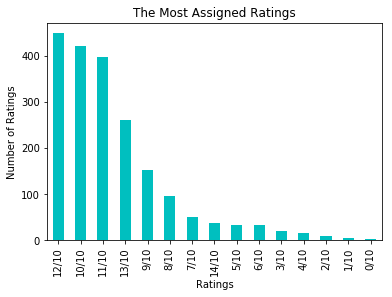

In [77]:
#Find the most assigned ratings
most_assigned_ratings = rating_list[:15]
most_assigned_ratings.plot(kind = 'bar', color = 'c')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.title('The Most Assigned Ratings');


In [67]:
# Make a list of most assigned ratings
most_assigned_ratings_list = list(most_assigned_ratings.index)

12/10, 10/10 and 11/10 are the most assigned ratings by 'we_rate_dogs'
<br> Top fifteeen assigned ratings all have denominator of 10. 

### The Most Rated Breeds

First we need to find the breed of each dog. 

In [68]:
def find_breed(tweet): # find the breed of dog based on it's confident level of image prediction
    #If prediction algorithem predicts something rather than dog, we won't consider it at all by setting
    #its conf value zero
    if not tweet.p1_dog:
        tweet.p1_conf = 0
    if not tweet.p2_dog:
        tweet.p2_dog = 0
    if not tweet.p3_dog:
        tweet.p3_dog = 0
    
    #if none of the predicions is a dog breed, return 'None'
    if tweet.p1_dog == 0 and tweet.p2_dog == 0 and tweet.p3_dog == 0:
        return(None)
    
    #The dog breed is the one with more "conf" value
    breed = tweet.p1
    breed_conf = tweet.p1_conf
    if tweet.p2_conf > breed_conf:
        breed = tweet.p2
        breed_conf = tweet.p2_conf      
    if  tweet.p3_conf > breed_conf:
        breed = tweet.p3
    return(breed)    
#Add and set 'breed' column to the dataset   
df_tweets['breed'] = df_tweets.apply(find_breed, axis=1)

In [69]:
#Find the top 15 breeds rated
breeds = df_tweets.breed.value_counts()
most_rated_breeds = breeds[:15]

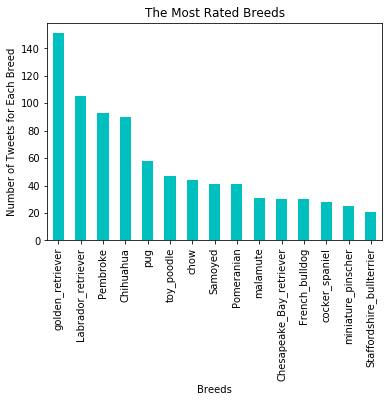

In [78]:
#Show the bar chart for the most rated breeds
most_rated_breeds.plot(kind = 'bar', color = 'c')
plt.xlabel('Breeds')
plt.ylabel('Number of Tweets for Each Breed')
plt.title('The Most Rated Breeds');

In [71]:
#make a list for most rated breeds 
most_rated_breeds_list = list(most_rated_breeds.index)

The Golden Retriever, and then Labrador Retriever and Pembroke breed has the highest number of dogs rated in our dataset.

### Statistics for 'likes', 'retweets' and 'Ratings'

To make a better sence of our result, first I want to filter my dataset for rows with rating in most_assigned_rating_list, because some ratings have unique and strange values like '204/170', '121/110', '143/130', etc.

In [72]:
#filter dataset with rows have rating in most_assigned_rating_list
df_selected = df_tweets[df_tweets.rating.isin(most_assigned_ratings_list)]
#change data type of rating_numerator to integer 
df_selected['rating_numerator'] = df_selected['rating_numerator'].astype('int64')
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1973 entries, 0 to 2066
Data columns (total 26 columns):
tweet_id                 1973 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1973 non-null datetime64[ns]
source                   1973 non-null object
text                     1973 non-null object
expanded_urls            1973 non-null object
rating_numerator         1973 non-null int64
rating_denominator       1973 non-null object
name                     1370 non-null object
dog_stage                318 non-null category
retweet_count            1973 non-null int64
favorite_count           1973 non-null int64
jpg_url                  1973 non-null object
img_num                  1973 non-null int64
p1                       1973 non-null object
p1_conf                  1973 non-null float64
p1_dog                   1973 non-null bool
p2                       1973 non-null object
p2_conf           

C:\Users\Simin\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
#Show statistics for 'likes' (favorite_count)
df_selected['favorite_count'].describe()

count    1973.000000  
mean     8794.694881  
std      12870.922358 
min      80.000000    
25%      1881.000000  
50%      3980.000000  
75%      11002.000000 
max      165088.000000
Name: favorite_count, dtype: float64

In [74]:
#Show Statistics for 'retweet_count'
df_selected['retweet_count'].describe() 

count    1973.000000 
mean     2679.026356 
std      4775.072297 
min      12.000000   
25%      594.000000  
50%      1282.000000 
75%      3072.000000 
max      84372.000000
Name: retweet_count, dtype: float64

In [75]:
df_selected['rating_numerator'].describe()

count    1973.000000
mean     10.551951  
std      2.182115   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating_numerator, dtype: float64

To understand and interprete easier, since all ratings in most_assigned_rating_list have denominator 10, I research the statistics just for the rating_numerator.

__ Statistics for 'likes', 'retweets' and 'rating_numerator' for the most rated breeds __

In [76]:
stat= (df_selected.query("breed in @most_rated_breeds_list")
                .groupby(['breed'], as_index = False)
                .agg({'favorite_count'  :['count', 'mean', 'max', 'min'],
                      'retweet_count'   :['mean', 'max', 'min'],
                      'rating_numerator':['mean', 'max', 'min']
                      }))
stat

breed favorite_count                             \
                                       count          mean     max  min   
0   Chesapeake_Bay_retriever   30             10004.000000  78870   165   
1   Chihuahua                  90             8329.222222   121324  124   
2   French_bulldog             30             19760.033333  122699  326   
3   Labrador_retriever         102            12104.127451  165088  307   
4   Pembroke                   93             10792.462366  68245   165   
5   Pomeranian                 40             7255.575000   64638   385   
6   Samoyed                    41             13689.804878  52800   780   
7   Staffordshire_bullterrier  21             8819.333333   36772   421   
8   chow                       44             9557.704545   75306   433   
9   cocker_spaniel             28             11325.392857  55601   284   
10  golden_retriever           148            11984.304054  82377   185   
11  malamute                   31             11047.709677  91185   219   
12  miniature_pinscher         25             7847.200000   33676   107   
13  pug                        58             6046.689655   35541   116   
14  toy_poodle                 47             6125.489362   48330   247   

   retweet_count             rating_numerator          
            mean    max  min             mean max min  
0   2632.966667   18914  53   10.800000        13  8   
1   2760.288889   59975  48   10.566667        14  3   
2   5212.233333   35737  118  11.166667        14  8   
3   3785.254902   84372  91   11.176471        14  7   
4   2968.032258   17958  83   11.387097        14  4   
5   2526.550000   18635  96   11.050000        14  6   
6   4679.439024   17564  239  11.731707        14  7   
7   2181.380952   10167  136  10.761905        13  8   
8   2745.022727   23812  204  11.522727        13  7   
9   3630.500000   29889  74   11.285714        13  9   
10  3573.608108   26413  51   11.641892        14  8   
11  3344.612903   31068  71   10.903226        13  8   
12  2196.960000   10580  40   10.000000        12  2   
13  1805.155172   9820   44   10.275862        13  3   
14  2165.553191   20282  84   11.042553        13  7

__Rating__
- __'Golden Retriever'__ has the most number of dogs rated by we_rate_dogs.
- __'Samoyed'__ bread has the highest average rating(11.73/10) and then __Golden Ritriever__ with rating 11.64/10. 
- The lowest rating(10/10) belongs to __Miniature_pinscher__ with 25 dogs rated.

__Likes__
- __French Bulldog__ has the highest average likes(19773)
- __pug__breed has the lowet average likes(6051). 



__Retweets__
- All these tweets have been retweeted for at least 40 times.
- The lowest retweet count(40) belongs to __Miniature Pinscher__, and the highest(84407) belongs to __Labrador Retriever__.
- On average __French Bulldog__ has the most number of retweets.


### Conclusion


Most of the rated dogs by "We Rate Dogs" are __Golden Retriever__, and they have the second average ratings among all the breeds, but looks like __French Bulldog__ was the breed that people liked and retweeted the most.